In [1]:
%matplotlib widget

import sys
import os.path as op
from glob import glob

import numpy as np
from scipy.io import loadmat
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import mne
from mne.io import read_epochs_eeglab
from mne.decoding import SSD
from mne.time_frequency import psd_array_multitaper

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# set path to SpectralEvents
sys.path.append('/users/rthorpe/brainstorm-ws/spectral-events')
import spectralevents as se

import pdb

In [2]:
def read_data(subj_id, series_num, data_dir, pick_channels=None):
    # read in both pre- and post-TMS sessions belonging to a single subject
    series_num = str(series_num)
    subj_id = subj_id.zfill(4)
    fname_t1 = op.join(data_dir, 'series_' + series_num, 'T1/preprocessed',
                       subj_id + '_Pre_Session1_Series' + series_num + '_Preprocessed.set')
    fname_t2 = op.join(data_dir, 'series_' + series_num, 'T2/preprocessed',
                       subj_id + '_Post_Session1_Series' + series_num + '_Preprocessed.set')

    # read in data
    epochs_pre_post = list()
    for fname in [fname_t1, fname_t2]:
        epochs = read_epochs_eeglab(fname)
        if pick_channels is not None:
            epochs = epochs.pick_channels(pick_channels)
        epochs_data = epochs.get_data().squeeze()
        #epochs_data -= np.mean(epochs_data, axis=(1, 2), keepdims=True)
        #epochs_data /= np.std(epochs_data, axis=(1, 2), keepdims=True)
        epochs_pre_post.append(epochs_data)
    epochs_info = epochs.info  # save for fit_ssd()
    epoch_times = epochs.times  # save save for spec_event_coherence_shift()
    
    return epochs_pre_post, epochs_info, epoch_times


def fit_ssd(data, ssd_info):
    """Alpha-band Spatio-Spectral Decomposition (SSD) from raw data"""
    #freqs_sig = 5, 8  # theta
    #freqs_noise = 4, 9  # theta
    #freqs_sig = 9, 14  # alpha
    #freqs_noise = 8, 15  # alpha
    freqs_sig = 15, 29  # beta
    freqs_noise = 14, 30  # beta
    #freqs_sig = 35, 45  # gamma
    #freqs_noise = 30, 50  # gamma

    ssd = SSD(info=ssd_info,
              reg='oas',
              sort_by_spectral_ratio=True,
              filt_params_signal=dict(l_freq=freqs_sig[0],
                                      h_freq=freqs_sig[1],
                                      l_trans_bandwidth=1,
                                      h_trans_bandwidth=1),
              filt_params_noise=dict(l_freq=freqs_noise[0],
                                     h_freq=freqs_noise[1],
                                     l_trans_bandwidth=1,
                                     h_trans_bandwidth=1))
    ssd.fit(X=data)
    return ssd


def spatio_spectral_shift(epochs_pre_post, epochs_info):
    
    n_comp = 20
    
    epochs_pre = epochs_pre_post[0]
    epochs_post = epochs_pre_post[1]
    epochs_agg = np.concatenate(epochs_pre_post, axis=0)
    
    ssd_patterns_all = list()
    ssd_patterns_norm_all = list()
    for epochs in [epochs_pre, epochs_post]:
        ssd = fit_ssd(epochs, epochs_info)
        # get top n_comp components
        ssd_patterns = ssd.patterns_[:n_comp]
        ssd_patterns_all.append(ssd_patterns)
        # normalize each vector independently
        ssd_patterns_norm = ssd_patterns / np.linalg.norm(ssd_patterns, axis=1, keepdims=True)
        ssd_patterns_norm_all.append(ssd_patterns_norm)
    
    A = np.linalg.pinv(ssd_patterns_norm_all[0]).T @ ssd_patterns_norm_all[1].T
    
    
    # compute stats across pre/post sessions
    ssd_std_diff = ssd_patterns_all[1].std() - ssd_patterns_all[0].std()
    #ssd_patterns_diff = ssd_patterns_all[1] - ssd_patterns_all[0]
    #ssd_patterns_diff_flip = ssd_patterns[1] + ssd_patterns[0]
    # note that some subjects have sessions where the spatial SSD pattern
    # remains consistent, but with opposite sign
    # given that an opposite sign of an SSD weight reflects a pi-radians phase
    # difference, here I explored the possibility that the sign assigned to a
    # given SSD vector is somewhat arbitrary by taking the SSD weight
    # difference with minimal magnitude
    #ssd_norm = min(np.sqrt(np.mean(ssd_patterns_diff ** 2)),
    #               np.sqrt(np.mean(ssd_patterns_diff_flip ** 2)))
    ssd_patterns_diff = (A @ ssd_patterns_norm_all[0]) - ssd_patterns_norm_all[1]
    ssd_norm = np.mean(np.sqrt(np.sum(ssd_patterns_diff ** 2, axis=1)))  # mean of the norms
    #ssd_norm = np.mean(np.sqrt(np.sum(A ** 2, axis=1)))
    return ssd_std_diff, ssd_norm


def spec_event_coherence_shift(epochs_pre_post, times):
    #event_band = [5, 8]  # theta band (Hz)
    event_band = [15, 29]  # beta band (Hz)
    #event_band = [9, 14]  # alpha band (Hz)
    thresh_FOM = 6.0  # factor-of-the-median threshold

    dt = times[1] - times[0]
    samp_freq = 1 / dt
    freqs = range(3, 40)
    
    time_bin = 0.05  # 50 ms; try 25 ms for beta 
    binned_times = np.arange(0, times[-1] + time_bin, time_bin)
    n_bins = len(binned_times)
    
    pre_post_coherence = list()
    for epochs_data in epochs_pre_post:
        n_epochs = epochs_data.shape[0]
        n_chans = epochs_data.shape[1]
        event_raster = list()
        for chan_idx in range(n_chans):
            chan_events = np.zeros((n_epochs, n_bins))  # to store binary event flags
            chan_epochs_data = epochs_data[:, chan_idx, :].squeeze()
            
            # compute TFRs
            tfrs = se.tfr(chan_epochs_data, freqs, samp_freq)
            # find events
            spec_events = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                                         event_band=event_band, threshold_FOM=6.)
            
            n_events = [len(epoch_events) for epoch_events in spec_events]
            print(f'Found {sum(n_events)} spectral events in current channel.')
            for epoch_idx, epoch_events in enumerate(spec_events):
                for event in epoch_events:
                    bin_idx = np.nonzero(binned_times > event['Peak Time'])[0][0]
                    chan_events[epoch_idx, bin_idx] = 1
            event_raster.append(chan_events)
            
            # sanity check: plot event_raster
            #plt.figure()
            #plt.pcolormesh(binned_times, np.arange(n_epochs), chan_events)
            
        event_intersection = event_raster[0] * event_raster[1]
        event_union = ((event_raster[0] + event_raster[1]) > 0).astype(int)
        sess_coherence = event_intersection.mean() / event_union.mean()
        
        print(f'Mean inter-hemisphere beta event coherence for current session: {sess_coherence}!!!')
        pre_post_coherence.append(sess_coherence)
    
    return pre_post_coherence[1] - pre_post_coherence[0]


def plot_features_scatter(x, y, responder_labels, ax_labels):
    '''Plot features across subjects in a 2D scatter plot.'''
    g = sns.JointGrid()

    for class_idx, class_ in enumerate(set(responder_labels)):
        if class_ == 1:
            label = 'responders'
        else:
            label = 'non-responders'
        cluster_mask = responder_labels == class_
        x_data = np.array(x)[cluster_mask]
        y_data = np.array(y)[cluster_mask]

        # plot data points for a given class label (i.e., responder or non-responder)
        sns.scatterplot(x=x_data, y=y_data, alpha=.5, edgecolor=None,
                        color=f'C{class_idx + 1}', ax=g.ax_joint)

        # plot marginal distributions for a given class label
        sns.kdeplot(x=x_data, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                    color=f'C{class_idx + 1}', ax=g.ax_marg_x, label=label)
        g.ax_marg_x.axvline(np.median(x_data), color=f'C{class_idx + 1}')
        sns.kdeplot(y=y_data, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                    color=f'C{class_idx + 1}', ax=g.ax_marg_y)
        g.ax_marg_y.axhline(np.median(y_data), color=f'C{class_idx + 1}')

    g.ax_joint.set_xlabel(ax_labels[0])
    g.ax_joint.set_ylabel(ax_labels[1])
    g.ax_marg_x.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.02))
    g.fig.tight_layout()

In [19]:
def cross_spectral_decomp(chan_data, lag):
    
    return components


def spec_spat_events(epochs_pre_post, times):
    event_band = [9, 14]  # alpha band (Hz)
    thresh_FOM = 6.0  # factor-of-the-median threshold

    dt = times[1] - times[0]
    samp_freq = 1 / dt
    freqs = freqs = range(3, 40)
    
    t_win = 0.1  # time window; 100 ms
    t_win_times = np.arange(0, t_win, dt))
    t_win_times = np.r_[-t_win_times[-1:0:-1], t_win_times[:]]
    t_margin = 0.1  # window margin; 100 ms


    for epochs_data in epochs_pre_post:
        # z-score data across channels and time
        epochs_data -= epochs_data.mean(axis=(1, 2), keepdims=True)
        epochs_data /= epochs_data.std(axis=(1, 2), keepdims=True)
        
        # z-score data across time (caution: removes some spatial patterns!)
        #epochs_data -= epochs_data.mean(axis=(2,), keepdims=True)
        #epochs_data /= epochs_data.std(axis=(2,), keepdims=True)
        
        for epoch_data in epochs_data:
            tfrs = se.tfr(epoch_data, freqs, samp_freq)
            # average TFR for this epoch across all channels
            tfr_chan_avg = np.mean(tfrs, axis=(0,))
            spec_events_global = se.find_events(tfr=tfr_chan_avg, times=times, freqs=freqs,
                                                event_band=event_band, threshold_FOM=6.)
            spec_events_global = spec_events_global[0]  # squeeze
            #fig = se.plot_events(tfr=tfr_chan_avg,
            #                     times=times,
            #                     freqs=freqs,
            #                     event_band=event_band,
            #                     spec_events=spec_events_global)
            event_times = np.array([event['Peak Time'] for event in spec_events_global])
            print(len(event_times))
            
            event_intervals = np.diff(event_times)
            event_times = event_times[event_times > ]
            post_event_windows = epoch_data
            
    return None


def get_features(subj_id, series_num, data_dir):
    '''Main pipeline for computing all features for a given subject.'''
    epochs_pre_post, _, times = read_data(subj_id, series_num, data_dir)
    spec_spat_features = spec_spat_events(epochs_pre_post, times)
    
    return spec_spat_features

In [9]:
# set data directory
data_dir = '/gpfs/data/brainstorm-ws/data/'
data_type = 'TRAINING'

In [10]:
# read metadata from master list
fname_master = op.join(data_dir, data_type, data_type + '_Master List_All Series.csv')
master_keys = np.loadtxt(fname_master,  delimiter=',', max_rows=1, dtype=str)
master_keys[0] = 'TMSID'  # fix first key string
master_values = np.loadtxt(fname_master, delimiter=',', skiprows=1, dtype=str)
master_info = {key: master_values[:, master_keys == key].squeeze() for key in master_keys}

# get subject IDs for subject series with both pre-/post-TMS EEG recordings
subj_select = master_info['HasT1T2'] == '1'
subj_ids = master_info['TMSID'][subj_select]
n_subj_series = sum(subj_select)

In [11]:
# read metadata from demographics and clinical outcomes
fname_outcomes = op.join(data_dir, data_type, data_type + '_Demographics and Clinical Outcomes_All Series.csv')
outcomes_keys = np.loadtxt(fname_outcomes,  delimiter=',', max_rows=1, dtype=str)
outcomes_keys[0] = 'TMSID'  # fix first key string
outcomes_values = np.loadtxt(fname_outcomes, delimiter=',', skiprows=1, dtype=str)
outcome_info = {key: outcomes_values[:, outcomes_keys == key].squeeze() for key in outcomes_keys}

# get demographic and outcome data for each subject series
ages = outcome_info['AgeTMSstart'][subj_select].astype(int)
sexes = outcome_info['Sex'][subj_select].astype(int)
depression_histories = outcome_info['SevHxDep'][subj_select].astype(int)
symptoms_init = outcome_info['IDSSRtot.Ses1'][subj_select].astype(int)
responders = outcome_info['LastRespIDSSR'][subj_select].astype(int)

# get series number for each subject series
series_nums = outcome_info['Series'][subj_select].astype(int)

## start test pipeline
--------------------

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0026_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
86 matching events found


/tmp/ipykernel_28270/3894718991.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_28270/3894718991.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
0
> /tmp/ipykernel_28270/3121197933.py(25)spec_spat_events()
     23         epochs_data /= epochs_data.std(axis=(2,), keepdims=True)
     24 
---> 25         for epoch_data in epochs_data:
     26             tfrs = se.tfr(epoch_data, freqs, samp_freq)
     27             # average TFR for this epoch across all channels

ipdb> exit


BdbQuit: 

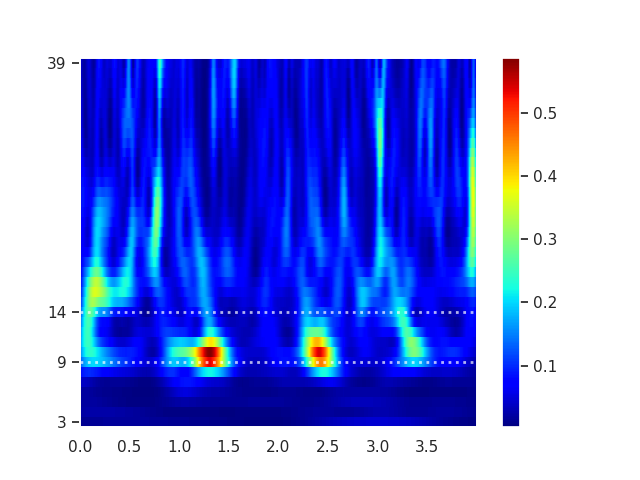

In [21]:
# test analysis pipeline
data_type_dir = op.join(data_dir, data_type)
spec_spat_features = get_features(subj_ids[0], series_nums[0], data_type_dir)

In [15]:
data_type_dir = op.join(data_dir, data_type)
epochs_pre_post, epochs_info, _ = read_data(subj_ids[0], series_nums[0], data_type_dir)
ssd_patterns_all = list()
for sess_idx, epochs_data in enumerate(epochs_pre_post):
    ssd = fit_ssd(epochs_data, epochs_info)
    ssd_patterns = ssd.patterns_[:4]
    ssd_patterns /= np.linalg.norm(ssd_patterns, axis=1, keepdims=True)
    ssd_patterns_all.append(ssd_patterns)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0026_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
86 matching events found


/tmp/ipykernel_118975/1695331099.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_118975/1695331099.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.8s finished


    Using tolerance 6.2e-12 (2.2e-16 eps * 64 dim * 4.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    2.1s finished


    Using tolerance 6.1e-12 (2.2e-16 eps * 64 dim * 4.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished


In [16]:
A = np.linalg.pinv(ssd_patterns_all[0]).T @ ssd_patterns_all[1].T

pre = ssd_patterns_all[0]
pre_trans = A @ ssd_patterns_all[0]
post = ssd_patterns_all[1]

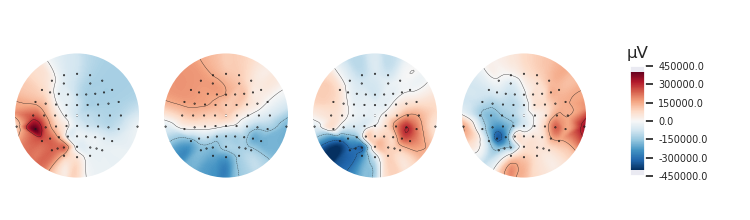

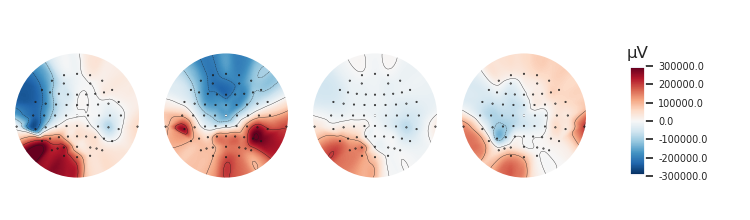

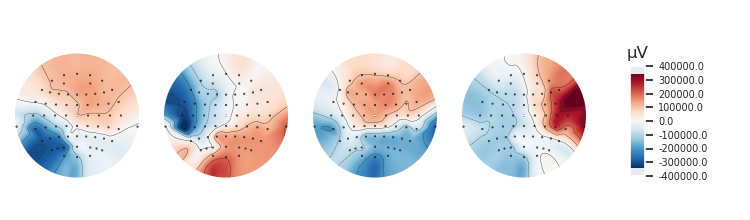

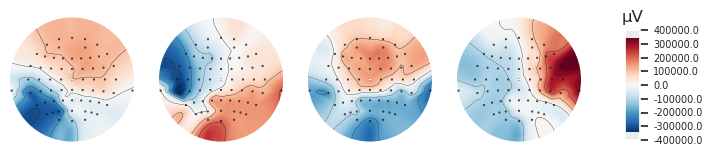

In [17]:
pattern = mne.EvokedArray(data=pre.T,
                          info=epochs_info)
pattern.plot_topomap(units=dict(mag='A.U.'), time_format='')

pattern = mne.EvokedArray(data=pre_trans.T,
                          info=epochs_info)
pattern.plot_topomap(units=dict(mag='A.U.'), time_format='')

pattern = mne.EvokedArray(data=post.T,
                          info=epochs_info)
pattern.plot_topomap(units=dict(mag='A.U.'), time_format='')

## end test pipeline
------------------------------

In [6]:
# run spatio-spectral and cross-hemisphere beta coherence features
# use embarrassingly parallel loop across subject series to speed things up
n_jobs = 24
data_type_dir = op.join(data_dir, data_type)
out = Parallel(n_jobs=n_jobs)(delayed(get_features)(subj_ids[idx], series_nums[idx], data_type_dir)
                              for idx in range(n_subj_series))
ssd_std_diffs, ssd_norms, spec_event_coherence_diffs = zip(*out)

# convert to numpy arrays
ssd_std_diffs = np.array(ssd_std_diffs)
ssd_norms = np.array(ssd_norms)
spec_event_coherence_diffs = np.array(spec_event_coherence_diffs)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_4/T1/preprocessed/0091_Pre_Session1_Series4_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
80 matching events found
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0167_Pre_Session1_Series2_Preprocessed.set...
No baseline correction applied
0 projection items activated
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0192_Pre_Session1_Series3_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0246_Pre_Session1_Series1_Preprocessed.set...
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocesse

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0295_Post_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0293_Post_Session1_Series1_Preprocessed.set...
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upp

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
    Using tolerance 5e-12 (2.2e-16 eps * 64 dim * 3.5e+02  max singular value)
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Computing rank from data with rank=None
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Estimating covariance using OAS
Computing rank from data with rank=None
    Using tolerance 5.4e-12 (2.2e-16 eps * 64 dim * 3.8e+02  max singular value)
    Estimated rank (eeg): 64
    EEG

Done.
Effective window size : 1.000 (s)
Done.
Reducing data rank from 64 -> 64
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Estimating covariance using OAS
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Done.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband ed

Effective window size : 1.000 (s)
Done.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Effective window size : 1.000 (s)
Done.
Effective window size : 1.000 (s)
Done.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff fre

Estimating covariance using OAS
    Using tolerance 2.5e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency:

Reducing data rank from 64 -> 64
Not setting metadata
72 matching events found
    Using tolerance 6.3e-12 (2.2e-16 eps * 64 dim * 4.4e+02  max singular value)
Estimating covariance using OAS
    Using tolerance 2e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
No baseline correction applied
0 projection items activated
    Using tolerance 4.2e-12 (2.2e-16 eps * 64 dim * 2.9e+02  max singular value)
Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0249_Post_Session1_Series1_Preprocessed.set...
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
43 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 5.1e-12 (2.2e-16 eps * 64

Computing rank from data with rank=None
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0293_Pre_Session1_Series1_Preprocessed.set...
    Using tolerance 1.7e-12 (2.2e-16 eps * 64 dim * 1.2e+02  max singular value)
Done.
Not setting metadata
101 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 1.2e-12 (2.2e-16 eps * 64 dim * 84  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0293_Post_Session1_Series1_Preprocessed.set...
Done.
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 7e-12 (2.2e-1

Not setting metadata
79 matching events found
Not setting metadata
67 matching events found
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0256_Pre_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0295_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
80 matching events found
    Using tolerance 4.9e-12 (2.2e-16 eps * 64 dim * 3.4e+02  max singular value)
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Ready.
Reducing data rank from 64 -> 64
Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preproc

    Using tolerance 2.9e-12 (2.2e-16 eps * 64 dim * 2e+02  max singular value)
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
    Using tolerance 1.7e-12 (2.2e-16 eps * 64 dim * 1.2e+02  max singular value)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 1.2e-11 (2.2e-16 eps * 64 dim * 8.2e+02  max singular value)
    Using tolerance 2.1e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0261_Pre_Session1_Series2_Preprocessed.set...
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
101 matching events found
Don

Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0326_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
93 matching events found
Not setting metadata
105 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0274_Post_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Found 335 spectral events in current channel.
Found 378 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.2700587084148728!!!
Found 289 spectral events in current channel.
Found 314 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.2810304449648712!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0330_Pre_Sessio

Found 353 spectral events in current channel.
Found 340 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.14234234234234233!!!
Found 259 spectral events in current channel.
Found 266 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.10313901345291479!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0336_Pre_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
No baseline correction applied
0 projection items activated
Ready.
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0296_Post_Session1_Series3_Preprocessed.set...
Found 263 spectral events in current channel.
Found 341 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.06792452830188679!!!
Found 326 spectral events in current channel.
Found 30

Computing rank from data with rank=None
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Computing rank from data with rank=None
Found 293 spectral events in current channel.
Found 364 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03754266211604096!!!
Found 252 spectral events in current channel.
Found 295 spectral

Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Estimating covariance using OAS
Computing rank from data with rank=None
Computing rank from data with rank=None
Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
-------------

No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 3.5e-12 (2.2e-16 eps * 64 dim * 2.5e+02  max singular value)
Found 420 spectral events in current channel.
Found 393 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.09523809523809526!!!
Found 308 spectral events in current channel.
Found 293 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.10159362549800796!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0357_Pre_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0356_Post_Session1_Series3_Preprocessed.set...
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
116 matching events found
Not setting metadata
96 matching events found
    Using tolerance 1.3e-11 (2.

Done.
Effective window size : 1.000 (s)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 4.7e-12 (2.2e-16 eps * 64 dim * 3.3e+02  max singular value)
Effective window size : 1.000 (s)
    Using tolerance 4.1e-12 (2.2e-16 eps * 64 dim * 2.9e+02  max singular value)
    Using tolerance 3.6e-12 (2.2e-16 eps * 64 dim * 2.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 da

Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 

Reducing data rank from 64 -> 64
    Using tolerance 1.6e-12 (2.2e-16 eps * 64 dim * 1.1e+02  max singular value)
Computing rank from data with rank=None
Estimating covariance using OAS
Done.
Done.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Computing rank from data 

Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 1.5e-11 (2.2e-16 eps * 64 dim * 1.1e+03  max singular value)
Done.
Reducing data rank from 64 -> 64
Done.
Estimating covariance using OAS
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Effective window size : 1.000 (s)
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0317_Pre_Session1_Series1_Preprocessed.set...
Estimating covariance using OAS
Not setting metadata
80 matching events found
Effective window size 

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0367_Post_Session1_Series1_Preprocessed.set...
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Not setting metadata
88 matching events found
Effective window size : 1.000 (s)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0330_Pre_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
99 matching events found
    Using tolerance 1.7e-12 (2.2e-16 eps * 64 dim * 1.2e+02  max singular value)
    Using tolerance 1.2e-11 (2.2e-16 eps * 64 dim * 8.1e+02  max singular value)
Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Done.
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
86 matching events found
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0340_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
84 matching events found
Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items ac

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
87 matching events found
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 8.8e-12 (2.2e-16 eps * 64 dim * 6.2e+02  max singular value)
No baseline correction applied
0 projection items activated
Computing rank from data with rank=None
Ready.
Done.
Reducing data rank from 64 -> 64
Estimating cov

Estimating covariance using OAS
No baseline correction applied
0 projection items activated
Ready.
Done.
Done.
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
99 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 1.5e-11 (2.2e-16 eps * 64 dim * 1e+03  max singular value)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Effective w

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0380_Post_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0355_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
72 matching events found
    Using tolerance 2.8e-12 (2.2e-16 eps * 64 dim * 2e+02  max singular value)
No baseline correction applied
0 projection items activated
Not setting metadata
107 matching events found
Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition ban

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5120 out of 5120 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Done.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 5.6e-12 (2.2e-16 eps * 64 dim * 4e+02  max singular value)
Effective window size : 1.000 (s)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Done.
    Using tolerance 3e-12 (2.2e-16 eps * 64 dim * 2.1e+02  max singular value)
    Estimated rank (eeg): 64
Setting up band-pass filter from 15 - 29 Hz


/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4608 out of 4608 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Not setting metadata
137 matching events found
Done.
    Using tolerance 2e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 9e-12 (2.2e-16 eps * 64 dim * 6.4e+02  max singular value)
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 9.8e-12 (2.2e-16 eps * 64 dim * 6.9e+02  max singular value)
Done.
Reducing data rank from 64 -> 64
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domai

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Effective window size : 1.000 (s)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Done.
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5120 out of 5120 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Reducing data rank from 64 -> 64
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6464 out of 6464 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Not setting metadata
113 matching events found
    Using tolerance 2.4e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 5.2e-12 (2.2e-16 eps * 64 dim * 3.7e+02  max singular value)
No baseline correction applied
0 projection items activated
Ready.
Reducing data rank from 64 -> 64
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0365_Post_Session1_Series1_Preprocessed.set...
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0357_Pre_Session1_Series1_Preprocessed.set...
Reducing data rank from 64 -> 64
Not setting metadata
100 matching events found
Estimating covarian

Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0409_Post_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0407_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
26 matching events found
Estimating covariance using OAS
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
76 matching events found
    Using tolerance 2.6e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lowe

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0413_Post_Session1_Series1_Preprocessed.set...
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
97 matching events found
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4608 out of 4608 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Estimating covariance using OAS
Reducing data rank from 64 -> 64
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0370_Pre_Session1_Series2_Preprocessed.set...
Estimating covariance using OAS
Not setting metadata
92 matching events found
Done.
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0370_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
78 matching events found
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 3.9e-12 (2.2e-16 eps * 64 dim * 2.8e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lo

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4864 out of 4864 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

    Using tolerance 9.5e-12 (2.2e-16 eps * 64 dim * 6.7e+02  max singular value)
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Estimating covariance using OAS
Done.
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
Done.
Computing rank from data with ran

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4736 out of 4736 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Reducing data rank from 64 -> 64
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Estimating covariance using OAS
Done.
    Using tolerance 4.8e-12 (2.2e-16 eps * 64 dim * 3.4e+02  max singular value)
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 3.8e-12 (2.2e-16 eps * 64 dim * 2.7e+02  max singular value)
Computing rank from data with rank=None
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Estimating covariance using OAS
Done.
Done.
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Estimating covariance using OAS
    Using tolerance 1e-11 (2.2e-16 eps * 64 dim * 7e+02  max singular value)
Effective window size : 1.000 (s)
Redu

Found 368 spectral events in current channel.
Found 421 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.021067415730337078!!!
Found 389 spectral events in current channel.
Found 453 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.04979253112033195!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0419_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
101 matching events found
Reducing data rank from 64 -> 64
Effective window size : 1.000 (s)
Estimating covariance using OAS
No baseline correction applied
0 projection items activated
Ready.
Done.
Reducing data rank from 64 -> 64
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0419_Post_Session1_Series1_Preprocessed.set...
Done.
Not setting metadata
76 matching events found
Estimating covariance using OAS
    Using tolerance 7.8e-12 (2

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6464 out of 6464 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0379_Pre_Session1_Series1_Preprocessed.set...
Reducing data rank from 64 -> 64
    Using tolerance 2.5e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
Not setting metadata
86 matching events found
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items act

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0379_Post_Session1_Series1_Preprocessed.set...
Computing rank from data with rank=None
Not setting metadata
86 matching events found
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
--------------

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6144 out of 6144 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Reducing data rank from 64 -> 64
    Using tolerance 7.7e-12 (2.2e-16 eps * 64 dim * 5.4e+02  max singular value)
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Computing rank from data with rank=None
Done.
Reducing data rank from 64 -> 64
    Using tolerance 3.2e-12 (2.2e-16 eps * 64 dim * 2.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Estimating covariance using OAS
Computing rank from data with rank=None
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition ban

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6592 out of 6592 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0409_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Ready.
Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0378_Pre_Session1_Series3_Preprocessed.set...
    Using tolerance 2.1e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
Computing rank from data with rank=None
Not setting metadata
111 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0378_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
98 matchin

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6784 out of 6784 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0423_Post_Session1_Series1_Preprocessed.set...
Done.
Reducing data rank from 64 -> 64
Not setting metadata
71 matching events found
Estimating covariance using OAS
No baseline correction applied
0 projection items activated
Ready.
Effective window size : 1.000 (s)
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5952 out of 5952 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Reducing data rank from 64 -> 64
Done.
Reducing data rank from 64 -> 64
    Using tolerance 1.9e-12 (2.2e-16 eps * 64 dim * 1.3e+02  max singular value)
Estimating covariance using OAS
Estimating covariance using OAS
Done.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0392_Pre_Session1_Seri

Done.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0401_Pre_Session1_Series1_Preprocessed.set...
Computing rank from data with rank=None
Computing rank from data with rank=None
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0401_Post_

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 7488 out of 7488 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Computing rank from data with rank=None
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
    Using tolerance 2.1e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
    Using tolerance 3.4e-12 (2.2e-16 eps * 64 dim * 2.4e+02  max singular value)
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Estimating covariance using OAS
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 1.3e-12 (2.2e-16 eps * 64 dim * 94  max singular value)
Done.
    Estimated rank (eeg): 64
   

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4352 out of 4352 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Computing rank from data with rank=None
Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0413_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
97 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0407_Pre_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Done.
Not setting metadata
119 matching events found
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB 

/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_10586/812961909.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6336 out of 6336 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Ready.
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Effective window size : 1.000 (s)
Done.
Found 319 spectral events in current channel.
Found 341 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.04736842105263158!!!
Found 273 spectral events in current channel.
Found 309 spectral events in current channel.
Mean inter-hemisphere beta event coherence for c

Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0469_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Ready.
Effective window size : 1.000 (s)
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firw

Ready.
Reducing data rank from 64 -> 64
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lo

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Effective window size : 1.000 (s)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0422_Pre_Session1_Series1_Preprocessed.set...
Done.
Not setting metadata
86 matching events found
Effective window size : 1.000 (s)
No baseline correction applied
0 projection items activated
Ready.
Computing rank fro

Effective window size : 1.000 (s)
Not setting metadata
81 matching events found
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 1.3e-12 (2.2e-16 eps * 64 dim * 95  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Reducing data rank from 64 -> 64
Estimating cova

Not setting metadata
106 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0436_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0436_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 7e-12 (2.2e-16 eps * 64 dim * 4.9e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming wind

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Reducing data rank from 64 -> 64
    Using tolerance 5.7e-12 (2.2e-16 eps * 64 dim * 4e+02  max singular value)
Effective window size : 1.000 (s)
    Using tolerance 1.9e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
Estimating covariance using OAS
    Using tolerance 9.5e-12 (2.2e-16 eps * 64 dim * 6.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Done.
Estimating covariance usi

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 H

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Done.
Done.
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0472_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0472_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0511_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Ready

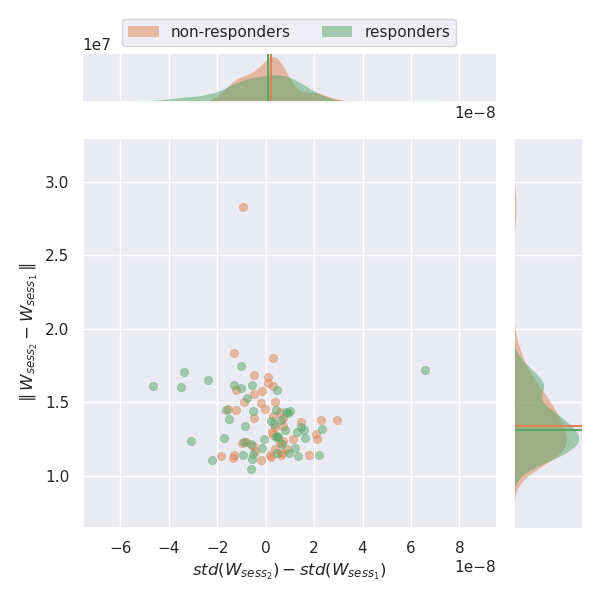

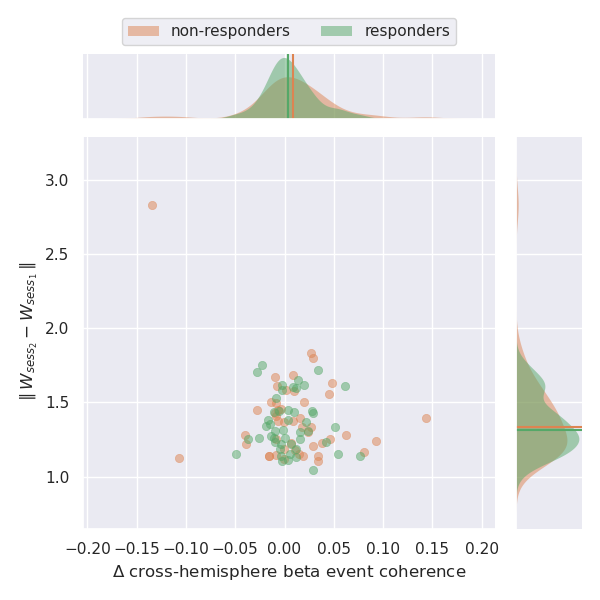

In [7]:
# plot 1st and 2nd features
ax_labels = [r'$std(W_{sess_2})-std(W_{sess_1})$', r'$\parallel W_{sess_2}-W_{sess_1}\parallel$']
plot_features_scatter(x=ssd_std_diffs, y=ssd_norms, responder_labels=responders, ax_labels=ax_labels)

# plot 1st and 3rd features
ax_labels = [r'$\Delta$ cross-hemisphere beta event coherence', r'$\parallel W_{sess_2}-W_{sess_1}\parallel$']
plot_features_scatter(x=spec_event_coherence_diffs, y=ssd_norms, responder_labels=responders, ax_labels=ax_labels)

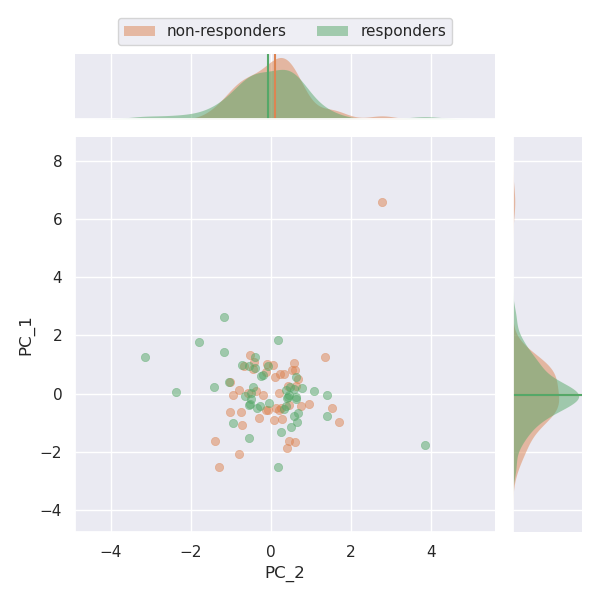

In [8]:
# PCA: see if the two data classes appear to be linearly separable
# answer: nope
X = np.c_[ssd_norms, ssd_std_diffs, spec_event_coherence_diffs]
X = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X)
pcs = pca.components_[:2, :]
X_pc = X @ pcs.T

ax_labels = ['PC_2', 'PC_1']
plot_features_scatter(x=X_pc[:, 1], y=X_pc[:, 0], responder_labels=responders, ax_labels=ax_labels)

In [9]:
X = np.c_[ssd_norms, ssd_std_diffs, spec_event_coherence_diffs, ages, sexes, depression_histories, symptoms_init]
X = StandardScaler().fit_transform(X)
svm_cls = svm.SVC(kernel='rbf')
svm_cls.fit(X, responders)
svm_cls.score(X, responders)

0.8105263157894737

In [10]:
n_perm = 1000
training_set_ratio = 0.7

n_set = n_subj_series
n_training_set = int(np.round(0.7 * n_set))
n_test_set = int(n_set - n_training_set)

accuracy_scores = np.zeros((n_perm,))
for perm_idx in range(n_perm):
    
    set_idxs = np.arange(n_set)
    np.random.shuffle(set_idxs)
    train_idxs = set_idxs[:n_training_set]
    test_idxs = set_idxs[n_training_set:]
    
    # fit to training set
    X_train = np.c_[ages[train_idxs],
                    sexes[train_idxs],
                    depression_histories[train_idxs],
                    symptoms_init[train_idxs]]
    std_scaler = StandardScaler().fit(X_train)
    X_train = std_scaler.transform(X_train)
    Y_train = responders[train_idxs]
    svm_cls = svm.SVC(kernel='rbf')
    svm_cls.fit(X_train, Y_train)
    
    # validate on test set
    X_test = np.c_[ages[test_idxs],
                   sexes[test_idxs],
                   depression_histories[test_idxs],
                   symptoms_init[test_idxs]]
    X_test = std_scaler.transform(X_test) 
    Y_test = responders[test_idxs]
    accuracy_scores[perm_idx] = svm_cls.score(X_test, Y_test)

print(f'Mean accuracy: {np.mean(accuracy_scores)}')

Mean accuracy: 0.502448275862069


In [13]:
n_perm = 1000
training_set_ratio = 0.7

n_set = n_subj_series
n_training_set = int(np.round(0.7 * n_set))
n_test_set = int(n_set - n_training_set)

accuracy_scores = np.zeros((n_perm,))
for perm_idx in range(n_perm):
    
    set_idxs = np.arange(n_set)
    np.random.shuffle(set_idxs)
    train_idxs = set_idxs[:n_training_set]
    test_idxs = set_idxs[n_training_set:]
    
    # fit to training set
    X_train = np.c_[ssd_norms[train_idxs],
                    ssd_std_diffs[train_idxs],
                    spec_event_coherence_diffs[train_idxs],
                    ages[train_idxs],
                    sexes[train_idxs],
                    depression_histories[train_idxs],
                    symptoms_init[train_idxs]]
    std_scaler = StandardScaler().fit(X_train)
    X_train = std_scaler.transform(X_train)
    Y_train = responders[train_idxs]
    svm_cls = svm.SVC(kernel='rbf')
    svm_cls.fit(X_train, Y_train)
    
    # validate on test set
    X_test = np.c_[ssd_norms[test_idxs],
                   ssd_std_diffs[test_idxs],
                   spec_event_coherence_diffs[test_idxs],
                   ages[test_idxs],
                   sexes[test_idxs],
                   depression_histories[test_idxs],
                   symptoms_init[test_idxs]]
    X_test = std_scaler.transform(X_test) 
    Y_test = responders[test_idxs]
    accuracy_scores[perm_idx] = svm_cls.score(X_test, Y_test)

print(f'Mean accuracy: {np.mean(accuracy_scores)}')

Mean accuracy: 0.47517241379310343
